In [1]:
import yaml
#
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
#
import torchaudio
import torchaudio.transforms as T
import torchaudio.functional as F
#
import torchvision
from torchvision.io import read_image
from torchvision.transforms import ConvertImageDtype
#
import matplotlib.pyplot as plt
#
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [2]:
print(torch.__version__)
print(torchaudio.__version__)
print(torchvision.__version__)

2.2.2+cu121
2.2.2+cu121
0.17.2+cu121


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
raw_path = 'data/raw/'
data_path = 'data/processed_spectrograms/'

In [5]:
labels = yaml.safe_load(open('labels.yaml'))

In [6]:
X, y = zip(*labels.items())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, shuffle=False)

In [7]:
def training(model, optimizer, criterion, dataloader):
    loss = 0
    y_true, y_score = [], []
    #
    model.train()
    for X, Y in dataloader:
        X, Y = X.to(device), Y.to(device, dtype=torch.float32)
        #
        output = model(X)
        loss = criterion(output.view(1), Y)
        #
        loss += loss.item()
        y_true.append(Y.item())
        y_score.append(torch.sigmoid(output).item())
        #
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss, roc_auc_score(y_true, y_score)


def testing(model, optimizer, criterion, dataloader):
    loss = 0
    y_true, y_score = [], []
    #
    model.eval()
    with torch.inference_mode():
        for X, Y in dataloader:
            X, Y = X.to(device), Y.to(device, dtype=torch.float32)
            #
            output = model(X)
            loss = criterion(output.view(1), Y)
            #
            loss += loss.item()
            y_true.append(Y.item())
            y_score.append(torch.sigmoid(output).item())
    #
    return loss, roc_auc_score(y_true, y_score)

# Modelling using images

In [27]:
class Podcast(Dataset):

    def __init__(self, X, y):
        self.x = X
        self.y = y
        self.cid = ConvertImageDtype(torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        label = self.y[idx]
        episode = self.x[idx]
        image = read_image(f'{data_path}/{episode}.png')
        return self.cid(image), int(label)

In [28]:
train = Podcast(X_train, y_train)
train_dataloader = DataLoader(train)

In [29]:
test = Podcast(X_test, y_test)
test_dataloader = DataLoader(test)

In [11]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(3, 3))
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(6, 6)),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(6, 6))
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(9, 9)),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=(512, 16))
        )
        #
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.33)
        self.linear1 = nn.Linear(8192, 128)
        self.linear2 = nn.Linear(128, 1)


    def forward(self, x):
        print(x.shape)
        x = self.layer1(x)
        print(x.shape)
        x = self.layer2(x)
        print(x.shape)
        x = self.layer3(x)
        print(x.shape)
        #
        x = self.flatten(x)
        print(x.shape)
        x = nn.functional.relu(self.linear1(x))
#         x = self.dropout(x, training=self.training)
        print(x.shape, self.training)
        #
        return self.linear2(x)


model = CNNet().to(device, dtype=torch.float32)

In [23]:
# class CNNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(4, 8, kernel_size=8, stride=2),
#             nn.AvgPool2d(kernel_size=4),
#             nn.ReLU(),
#         )
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(8, 16, kernel_size=16, stride=2),
#             nn.AvgPool2d(kernel_size=8),
#             nn.ReLU(),
#         )
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(16, 32, kernel_size=32, stride=2),
#             nn.AvgPool2d(kernel_size=16),
#             nn.ReLU(),
#         )
#         self.flatten = nn.Flatten()
#         self.dropout = nn.Dropout(0.33)
#         self.linear1 = nn.Linear(256, 32)
#         self.linear2 = nn.Linear(32, 1)


#     def forward(self, x):
#         x = self.layer1(x)
#         print(x.shape)
#         x = self.layer2(x)
#         print(x.shape)
#         x = self.layer3(x)
#         print(x.shape)
#         #    
#         x = self.flatten(x)
#         print(x.shape)
#         x = nn.functional.relu(self.linear1(x))
# #         x = self.dropout(x, training=self.training)
#         print(x.shape, self.training)
#         #
#         return self.linear2(x)  

# model = CNNet().to(device, dtype=torch.float32)

In [24]:
model

CNNet(
  (layer1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(8, 8), stride=(2, 2))
    (1): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(16, 16), stride=(2, 2))
    (1): AvgPool2d(kernel_size=8, stride=8, padding=0)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(32, 32), stride=(2, 2))
    (1): AvgPool2d(kernel_size=16, stride=16, padding=0)
    (2): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.33, inplace=False)
  (linear1): Linear(in_features=256, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=1, bias=True)
)

In [37]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [51]:
y_score = []
y_true = []

model.train()
for idx, (X, y) in enumerate(train_dataloader):

    X, y = X.to(device), y.to(device)
    #
    output = model(X)
    loss = criterion(output[0], y)
    #
    optimizer.zero_grad()
    #
    print(output.view(1), y)
    print(loss)
    y_score.append(loss.item())
    y_true.append(y.item())
    #
    loss.backward()
    optimizer.step()

torch.Size([1, 8, 2755, 1846])
torch.Size([1, 16, 171, 114])
torch.Size([1, 32, 4, 2])
torch.Size([1, 256])
torch.Size([1, 32]) True
tensor([-0.0032], grad_fn=<ViewBackward0>) tensor([1.], dtype=torch.float64)
tensor(0.6947, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
torch.Size([1, 8, 2755, 1846])
torch.Size([1, 16, 171, 114])
torch.Size([1, 32, 4, 2])
torch.Size([1, 256])
torch.Size([1, 32]) True
tensor([-0.0031], grad_fn=<ViewBackward0>) tensor([0.], dtype=torch.float64)
tensor(0.6916, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
torch.Size([1, 8, 2755, 1846])
torch.Size([1, 16, 171, 114])
torch.Size([1, 32, 4, 2])
torch.Size([1, 256])
torch.Size([1, 32]) True
tensor([-0.0030], grad_fn=<ViewBackward0>) tensor([0.], dtype=torch.float64)
tensor(0.6916, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
torch.Size([1, 8, 2755, 1846])
torch.Size([1, 16, 171, 114])
torch.Size([1, 32, 4, 2])
torch.S

In [52]:
roc_auc_score(y_true, y_score)

1.0

In [54]:
y_score = []
y_true = []

model.eval()
with torch.no_grad():
    for X, y in test_dataloader:
        print('.', end='')
        #
        X, y = X.to(device), y.to(device)
        output = model(X)
        #
        y_score.append(
            criterion(output[0], y).item()
        )
        y_true.append(y.item())
        #
        print(y_score[-1], output, y)
#         test_loss += cost(pred, Y).item()
#         correct += (pred.argmax(1)==Y).type(torch.float).sum().item()

.torch.Size([1, 8, 2755, 1846])
torch.Size([1, 16, 171, 114])
torch.Size([1, 32, 4, 2])
torch.Size([1, 256])
torch.Size([1, 32]) False
0.691569983959198 tensor([[-0.0032]]) tensor([0.], dtype=torch.float64)
.torch.Size([1, 8, 2755, 1846])
torch.Size([1, 16, 171, 114])
torch.Size([1, 32, 4, 2])
torch.Size([1, 256])
torch.Size([1, 32]) False
0.6916375160217285 tensor([[-0.0030]]) tensor([0.], dtype=torch.float64)
.torch.Size([1, 8, 2755, 1846])
torch.Size([1, 16, 171, 114])
torch.Size([1, 32, 4, 2])
torch.Size([1, 256])
torch.Size([1, 32]) False
0.694721382111311 tensor([[-0.0031]]) tensor([1.], dtype=torch.float64)
.torch.Size([1, 8, 2755, 1846])
torch.Size([1, 16, 171, 114])
torch.Size([1, 32, 4, 2])
torch.Size([1, 256])
torch.Size([1, 32]) False
0.694707565009594 tensor([[-0.0031]]) tensor([1.], dtype=torch.float64)
.torch.Size([1, 8, 2755, 1846])
torch.Size([1, 16, 171, 114])
torch.Size([1, 32, 4, 2])
torch.Size([1, 256])
torch.Size([1, 32]) False
0.691636860370636 tensor([[-0.0030]]

In [47]:
from sklearn.metrics import roc_auc_score, average_precision_score

In [56]:
roc_auc_score(y_true, y_score)

1.0

In [57]:
average_precision_score(y_true, y_score)

1.0

# Modelling `as is`

In [8]:
class Podcast(Dataset):

    def __init__(self, X, y):
        self.x = X
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        label = self.y[idx]
        episode = self.x[idx]
        #
        waveform, sample_rate = torchaudio.load(f'{raw_path}/{episode}.mp3')
        print(sample_rate, episode)
        #
        return self.get_spectrogram(waveform, sample_rate), label

    def get_spectrogram(self, waveform, sample_rate):
        spectrogram = T.Spectrogram(
            n_fft=sample_rate,
            hop_length=sample_rate // 2,
        )
        a2db = T.AmplitudeToDB(top_db=80)
        return a2db(
            spectrogram(waveform.mean(dim=0))
        )

In [9]:
train = Podcast(X_train, y_train)
train_dataloader = DataLoader(train, shuffle=True)

In [10]:
test = Podcast(X_test, y_test)
test_dataloader = DataLoader(test)

In [11]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(3, 3))
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(6, 6)),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(6, 6))
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(9, 9)),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=(512, 16))
        )
        #
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.33)
        self.linear1 = nn.Linear(8192, 128)
        self.linear2 = nn.Linear(128, 1)


    def forward(self, x):
        print(x.shape)
        x = self.layer1(x)
        print(x.shape)
        x = self.layer2(x)
        print(x.shape)
        x = self.layer3(x)
        print(x.shape)
        #
        x = self.flatten(x)
        print(x.shape)
        x = nn.functional.relu(self.linear1(x))
#         x = self.dropout(x, training=self.training)
        print(x.shape, self.training)
        #
        return self.linear2(x)  


model = CNNet().to(device, dtype=torch.float32)

In [12]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(100):
    train_loss, train_auc = training(model, optimizer, criterion, train_dataloader)
    test_loss, test_auc = testing(model, optimizer, criterion, test_dataloader)
    #
    print(f'Epoch: {epoch} | Training loss: {train_loss:.4f} | Testing loss: {test_loss:.4f} | Training AUC: {train_auc:.4f} | Testing AUC: {test_auc:.4f}')

44100 560
torch.Size([1, 22051, 473])
torch.Size([1, 7349, 157])
torch.Size([1, 1224, 25])
torch.Size([1, 512, 16])
torch.Size([1, 8192])
torch.Size([1, 128]) True
44100 608
torch.Size([1, 22051, 424])
torch.Size([1, 7349, 140])
torch.Size([1, 1224, 22])
torch.Size([1, 512, 16])
torch.Size([1, 8192])
torch.Size([1, 128]) True
44100 581
torch.Size([1, 22051, 9916])
torch.Size([1, 7349, 3304])
torch.Size([1, 1224, 549])
torch.Size([1, 512, 16])
torch.Size([1, 8192])
torch.Size([1, 128]) True
44100 566
torch.Size([1, 22051, 402])
torch.Size([1, 7349, 133])
torch.Size([1, 1224, 21])
torch.Size([1, 512, 16])
torch.Size([1, 8192])
torch.Size([1, 128]) True
44100 554
torch.Size([1, 22051, 595])
torch.Size([1, 7349, 197])
torch.Size([1, 1224, 32])
torch.Size([1, 512, 16])
torch.Size([1, 8192])
torch.Size([1, 128]) True
44100 569
torch.Size([1, 22051, 5070])
torch.Size([1, 7349, 1689])
torch.Size([1, 1224, 280])
torch.Size([1, 512, 16])
torch.Size([1, 8192])
torch.Size([1, 128]) True
44100 583


## Test

In [40]:
episode = 553

In [28]:
cache_file = 'data.yaml'
raw_path = 'data/raw/'
cmap = 'Greys'

In [29]:
cache = yaml.safe_load(open(cache_file))

In [41]:
metadata = torchaudio.info(f'{raw_path}/{episode}.mp3')
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=283033712, num_channels=2, bits_per_sample=0, encoding=MP3)


In [42]:
waveform, sample_rate = torchaudio.load(f'{raw_path}/{episode}.mp3')
waveform = waveform.mean(dim=0)  # make mono from stereo by averaring
waveform.shape

torch.Size([283033712])

In [43]:
spectrogram = T.Spectrogram(
    n_fft=sample_rate,
    hop_length=sample_rate // 2,
)
a2db = T.AmplitudeToDB(top_db=80)

In [44]:
s = spectrogram(waveform)
s = a2db(s)
s.shape

torch.Size([22051, 12836])

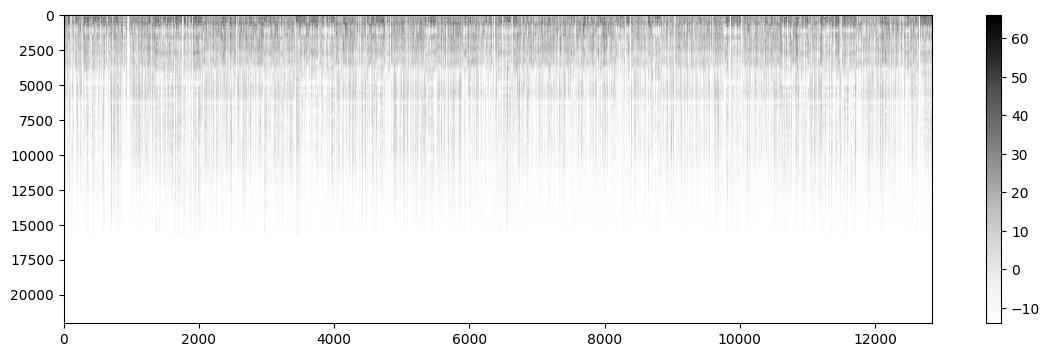

In [45]:
plt.figure(figsize=(14, 4))
plt.imshow(s.numpy(), aspect='auto', cmap=cmap)
plt.colorbar()

In [81]:
cl1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(3, 3)),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=(3, 3))
)

In [82]:
cl2 = nn.Sequential(
    nn.Conv2d(in_channels=2, out_channels=4, kernel_size=(6, 6)),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=(6, 6))
)

In [83]:
cl3 = nn.Sequential(
    nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(9, 9)),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(output_size=(512, 16))
)

In [87]:
s.unsqueeze(dim=0).unsqueeze(0).shape

torch.Size([1, 1, 22051, 12836])

In [139]:
s.unsqueeze(dim=0).shape

torch.Size([1, 24001, 269])

In [93]:
out = cl1(s.unsqueeze(dim=0).unsqueeze(dim=0))
out.shape

torch.Size([1, 2, 7349, 4278])

In [94]:
out = cl2(out)
out.shape

torch.Size([1, 4, 1224, 712])

In [95]:
out = cl3(out)
out.shape

torch.Size([1, 8, 512, 16])

In [96]:
flatten = nn.Flatten()
flatten(out).shape

torch.Size([1, 65536])

In [73]:
out.shape

torch.Size([1, 512, 16])

In [79]:
clf = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=8192, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=1)
)

In [80]:
clf(out).view(1)

tensor([0.0394], grad_fn=<ViewBackward0>)

In [14]:
def train(dataloader, model, criterion, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, Y) in enumerate(dataloader):

        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output.view(1), Y.type(torch.FloatTensor))
        #
        print(output.view(1), Y)
        print(loss)
        #
        loss.backward()
        optimizer.step()
        
#         print(loss)
#         if batch % 100 == 0:
#             current = batch * len(X)
#             print(f'loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')

In [ ]:
model.eval()
test_loss, correct = 0, 0
class_map = ['no', 'yes']

with torch.no_grad():
    for batch, (X, Y) in enumerate(test_dataloader):
        X, Y = X.to(device), Y.to(device)
        pred = model(X)
        print("Predicted:\nvalue={}, class_name= {}\n".format(pred[0].argmax(0),class_map[pred[0].argmax(0)]))
        print("Actual:\nvalue={}, class_name= {}\n".format(Y[0],class_map[Y[0]]))
        break

In [ ]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            pred = model(X)

            test_loss += cost(pred, Y).item()
            correct += (pred.argmax(1)==Y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size

    print(f'\nTest Error:\nacc: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f}\n')

In [15]:
epochs = 15

for t in range(epochs):
    print(f'Epoch {t+1}\n-------------------------------')
    train(train_dataloader, model, criterion, optimizer)
    test(test_dataloader, model)
print('Done!')

Epoch 1
-------------------------------
580 torch.Size([4, 22051, 14776])
torch.Size([1, 128, 340, 226])
torch.Size([1, 9835520])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x9835520 and 739840x64)

- https://wandb.ai/ayush-thakur/dl-question-bank/reports/How-to-Handle-Images-of-Different-Sizes-in-a-Convolutional-Neural-Network--VmlldzoyMDk3NzQ

- https://blog.paperspace.com/global-pooling-in-convolutional-neural-networks/

## + Augmentation

In [ ]:
from IPython.display import Audio

In [ ]:
episode = 742

In [ ]:
waveform, sample_rate = torchaudio.load(f'{raw_path}/{episode}.mp3')
waveform = waveform.mean(dim=0)  # make mono from stereo by averaring

In [ ]:
Audio(waveform[:waveform.shape[0] // 10], rate=sample_rate)

In [ ]:
plt.figure(figsize=(14, 4))
plt.plot(waveform.numpy(), ls='--', color='grey', lw=0.05)

In [52]:
import random

In [65]:
probas = [0.1, 0.4, 0.2, 0.3]
size = 10
result = []

res = [0]
for p in probas:
    res.append(res[-1]+p)
        
# res
for _ in range(size):
#     print(random.random())
    rr = random.random()
    print(rr)
    for idx in range(len(res)-1):
        print(res[idx], res[idx+1], result)
        if rr >= res[idx] and rr < res[idx+1]:
            print(idx)
            result.append(idx)
            break
            
print(res, result)

0.03358662964523873
0 0.1 []
0
0.3405022703178888
0 0.1 [0]
0.1 0.5 [0]
1
0.12637400239713015
0 0.1 [0, 1]
0.1 0.5 [0, 1]
1
0.7956959568389843
0 0.1 [0, 1, 1]
0.1 0.5 [0, 1, 1]
0.5 0.7 [0, 1, 1]
0.7 1.0 [0, 1, 1]
3
0.021017163545093864
0 0.1 [0, 1, 1, 3]
0
0.2790766399824478
0 0.1 [0, 1, 1, 3, 0]
0.1 0.5 [0, 1, 1, 3, 0]
1
0.19695354310223356
0 0.1 [0, 1, 1, 3, 0, 1]
0.1 0.5 [0, 1, 1, 3, 0, 1]
1
0.1389510492928656
0 0.1 [0, 1, 1, 3, 0, 1, 1]
0.1 0.5 [0, 1, 1, 3, 0, 1, 1]
1
0.3078099601608696
0 0.1 [0, 1, 1, 3, 0, 1, 1, 1]
0.1 0.5 [0, 1, 1, 3, 0, 1, 1, 1]
1
0.5177160995077268
0 0.1 [0, 1, 1, 3, 0, 1, 1, 1, 1]
0.1 0.5 [0, 1, 1, 3, 0, 1, 1, 1, 1]
0.5 0.7 [0, 1, 1, 3, 0, 1, 1, 1, 1]
2
[0, 0.1, 0.5, 0.7, 1.0] [0, 1, 1, 3, 0, 1, 1, 1, 1, 2]


In [51]:
seq = [1, 1, 0, 0, 1, 1]
# seq = [1, 1, 0, 0, 1, 1, 1]
# seq = [0, 0, 0]
# seq = []
res = 0
tmp = 0
for el in seq:
    if el == 1:
        tmp += 1
        res = max(res, tmp)
    else:
        tmp = 0
    
    
print(res)

2


In [40]:
len(podcast)

78

In [12]:
yaml.safe_load(open(cache_file, 'r'))[571]

{'day': 3,
 'dow': 'Tuesday',
 'month': 'May',
 'year': 2022,
 'title': 'SDS 571: Collaborative, No-Code Machine Learning',
 'duration': 58,
 'link': 'https://www.youtube.com/embed/c5LyEtZcxiY',
 'stats': 41.5}

# Links

- https://github.com/daisukelab/ml-sound-classifier

- https://www.kaggle.com/c/freesound-audio-tagging

- https://github.com/daisukelab/sound-clf-pytorch

- https://clear.ml/blog/audio-classification-with-pytorchs-ecosystem-tools

- https://www.kaggle.com/code/aayush9753/audio-classification-starter-in-pytorch

- https://blogs.rstudio.com/ai/posts/2022-10-06-audio-classification-torch/

- https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/audio_classifier_tutorial.ipynb

- https://bamblebam.medium.com/audio-classification-and-regression-using-pytorch-48db77b3a5ec

- https://www.kaggle.com/code/psycheshaman/pytorch-human-speech-classification

- https://huggingface.co/docs/transformers/tasks/audio_classification

- https://github.com/huggingface/transformers/blob/main/examples/pytorch/audio-classification/README.md

- https://music-classification.github.io/tutorial/part3_supervised/tutorial.html

- https://medium.com/@mlg.fcu/using-python-to-classify-sounds-a-deep-learning-approach-ef00278bb6ad

- https://www.youtube.com/watch?v=TkwXa7Cvfr8&t=1251s

- https://www.youtube.com/watch?v=O5xeyoRL95U

- https://medium.com/mlearning-ai/music-genre-classification-using-cnn-part-2-classification-ee5400cfbc4f

In [41]:
podcast[0]

610 torch.Size([4, 22051, 662])


(tensor([[[201, 188, 251,  ..., 255, 255, 255],
          [220, 192, 241,  ..., 242, 255, 255],
          [213, 193, 234,  ..., 235, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]],
 
         [[201, 188, 251,  ..., 255, 255, 255],
          [220, 192, 241,  ..., 242, 255, 255],
          [213, 193, 234,  ..., 235, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]],
 
         [[201, 188, 251,  ..., 255, 255, 255],
          [220, 192, 241,  ..., 242, 255, 255],
          [213, 193, 234,  ..., 235, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]],
 
         [[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 25

In [19]:
cache = yaml.safe_load(open('data.yaml', 'r'))

In [20]:
popularity_dict = {el: cache[el]['stats'] for el in cache if cache[el]['year'] == 2022}
len(popularity_dict)

104

In [21]:
sorted(popularity_dict.items(), key=lambda x: x[1])[0]

(638, 20.0)

In [22]:
sorted(popularity_dict.items(), key=lambda x: x[1])[-1]

(537, 48.7)

# Sources

- https://speechprocessingbook.aalto.fi/Representations/Melcepstrum.html

- https://mmchiou.gitbooks.io/uwsgi/content/tensorflow-speech-recognition-challenge/kernel/speech-representation-and-data-exploration/notebooksrde/visualizationspae.html

- https://vtiya.medium.com/mfcc-vs-mel-spectrogram-8f1dc0abbc62

- https://ketanhdoshi.github.io/Audio-ASR/

- https://towardsdatascience.com/audio-deep-learning-made-simple-part-2-why-mel-spectrograms-perform-better-aad889a93505

- https://www-i6.informatik.rwth-aachen.de/publications/download/937/T%7Bu%7DskeZolt%7Ba%7DnGolikPavelSchl%7Bu%7DterRalfNeyHermann--AcousticModelingwithDeepNeuralNetworksUsingRawTimeSignalfor%7BLVCSR%7D--2014.pdf
